# **Machine Learning on Big Data (CN7030) CRWK 23-24 Term B [60% weighting]**
# **Exploring World Development Indicators: Identifying relationship between Health Indicators using Linear Regression & Classification of Income Group based on Health Indicators using Logistic Regression.**
# **Group ID: 16**
1.   Student 1: Brintha Thirunavukkarasu and 2555470
2.   Student 2: Samar Ahmed and 2596741


# **Initiate and Configure Spark**

In [3]:
!pip3 install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=4732fa1f1bca5d8109009ac9580bdedc46375179837d7e208a87623adeb15b27
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [5]:
# import modules
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import when, col, udf, sum, avg, stddev, rand
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler, MinMaxScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.types import DoubleType
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import matplotlib.pyplot as plt
import numpy as np
import random

In [4]:
# Create spark session
spark = SparkSession.builder \
                    .appName("project_df") \
                    .master("local[*]") \
                    .config("spark.executor.memory", "4g") \
                    .config("spark.driver.memory", "2g") \
                    .config("spark.executor.cores", "2") \
                    .config("spark.sql.inMemoryColumnarStorage.compressed", "true") \
                    .getOrCreate()

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


---
# **Task 1 - Data Loading and Preprocessing (15 marks)**
---

Dataset : https://www.kaggle.com/datasets/kaggle/world-development-indicators \
Size: 387 MB (Compressed Zip file)\
1.90 GB (Uncompressed)

# Student 1

**1.Introduction**

The World Development Indicators (WDI) are a collection of timely, outstanding, and globally comparable information regarding the battle against poverty and global development. It is created by the World Bank and contains information on 1,600 indicators for 217 countries for more than 50 years, including infrastructure, the environment, health, education, and poverty (World Bank, 2024).


In [102]:
indicators_df=spark.read.csv("/content/drive/MyDrive/NIndicators.csv",inferSchema=True,header=True)
indicators_df.show(5)

+-----------+-----------+--------------------+--------------+----+------------------+
|CountryName|CountryCode|       IndicatorName| IndicatorCode|Year|             Value|
+-----------+-----------+--------------------+--------------+----+------------------+
| Arab World|        ARB|Adolescent fertil...|   SP.ADO.TFRT|1960|133.56090740552298|
| Arab World|        ARB|Age dependency ra...|   SP.POP.DPND|1960|  87.7976011532547|
| Arab World|        ARB|Age dependency ra...|SP.POP.DPND.OL|1960| 6.634579191565161|
| Arab World|        ARB|Age dependency ra...|SP.POP.DPND.YG|1960| 81.02332950839141|
| Arab World|        ARB|Arms exports (SIP...|MS.MIL.XPRT.KD|1960|         3000000.0|
+-----------+-----------+--------------------+--------------+----+------------------+
only showing top 5 rows



In [103]:
indicators_df.count()

5656458

In [104]:
indicators_df.rdd.getNumPartitions()
indicators_df = indicators_df.repartition(5)

**2.Filter**

Prioritising health indicators among the many that are available is important since health is a key component of sustainable development objectives for every country. Filtering indicator which is related with **Health: Nutrition** and **Health: Mortality**. List of indicator taken from other csv file.



In [105]:
series_df=spark.read.csv("/content/drive/MyDrive/Series.csv",inferSchema=True,header=True)
series_df.show(2)

+--------------------+--------------------+--------------------+---------------+--------------------+-------------+-----------+----------+----------+-----------------+------------------------+-----------------------+--------------------+--------------------+--------------------------------+--------------------+------------------+-------------+-----------------+-----------+
|          SeriesCode|               Topic|       IndicatorName|ShortDefinition|      LongDefinition|UnitOfMeasure|Periodicity|BasePeriod|OtherNotes|AggregationMethod|LimitationsAndExceptions|NotesFromOriginalSource|     GeneralComments|              Source|StatisticalConceptAndMethodology|DevelopmentRelevance|RelatedSourceLinks|OtherWebLinks|RelatedIndicators|LicenseType|
+--------------------+--------------------+--------------------+---------------+--------------------+-------------+-----------+----------+----------+-----------------+------------------------+-----------------------+--------------------+-----------

In [106]:
series = series_df.filter((series_df["Topic"]== 'Health: Nutrition') | (series_df["SeriesCode"]== 'SP.DYN.IMRT.IN'))
series.select("Topic",'SeriesCode','IndicatorName').show(truncate=False)

+-----------------+-----------------+-------------------------------------------------------------------------------+
|Topic            |SeriesCode       |IndicatorName                                                                  |
+-----------------+-----------------+-------------------------------------------------------------------------------+
|Health: Mortality|SP.DYN.IMRT.IN   |Mortality rate, infant (per 1,000 live births)                                 |
|Health: Nutrition|SN.ITK.SALT.ZS   |Consumption of iodized salt (% of households)                                  |
|Health: Nutrition|SN.ITK.DFCT      |Depth of the food deficit (kilocalories per person per day)                    |
|Health: Nutrition|SH.STA.BFED.ZS   |Exclusive breastfeeding (% of children under 6 months)                         |
|Health: Nutrition|SH.STA.BRTW.ZS   |Low-birthweight babies (% of births)                                           |
|Health: Nutrition|SH.ANM.CHLD.ZS   |Prevalence of anemi

Choosing indicators only related to Infant.

In [107]:
indicators = ['SH.STA.BFED.ZS', 'SH.STA.BRTW.ZS', 'SH.ANM.CHLD.ZS', 'SH.STA.OWGH.ZS', 'SH.SVR.WAST.ZS', 'SH.STA.STNT.ZS','SN.ITK.DEFC.ZS', 'SH.STA.MALN.ZS',
              'SH.STA.WAST.ZS', 'SN.ITK.VITA.ZS', 'SH.DTH.IMRT']
final_df = indicators_df.filter(col("IndicatorCode").isin(indicators))
#Changing names for each indicator code
old_values = ['SH.STA.BFED.ZS', 'SH.STA.BRTW.ZS', 'SH.ANM.CHLD.ZS', 'SH.STA.OWGH.ZS', 'SH.SVR.WAST.ZS', 'SH.STA.STNT.ZS', 'SN.ITK.DEFC.ZS', 'SH.STA.MALN.ZS',
              'SH.STA.WAST.ZS', 'SN.ITK.VITA.ZS', 'SH.DTH.IMRT']
new_values = ["infant_feeding", "low_birthweight", "anemia", "overweight","overwasting","stunting","undernourishment", "underweight","wasting","vitaminA_def",
              "mortality"]
column_mapping = dict(zip(old_values, new_values))
for old_value, new_value in column_mapping.items():
    final_df = final_df.withColumn("IndicatorCode", when(final_df["IndicatorCode"] == old_value, new_value).otherwise(final_df["IndicatorCode"]))

In [108]:
# final indicators
unique = final_df.select("IndicatorCode","IndicatorName").distinct()
unique.show(truncate = False)

+----------------+------------------------------------------------------------------------+
|IndicatorCode   |IndicatorName                                                           |
+----------------+------------------------------------------------------------------------+
|vitaminA_def    |Vitamin A supplementation coverage rate (% of children ages 6-59 months)|
|stunting        |Prevalence of stunting, height for age (% of children under 5)          |
|undernourishment|Prevalence of undernourishment (% of population)                        |
|infant_feeding  |Exclusive breastfeeding (% of children under 6 months)                  |
|underweight     |Prevalence of underweight, weight for age (% of children under 5)       |
|wasting         |Prevalence of wasting, weight for height (% of children under 5)        |
|mortality       |Number of infant deaths                                                 |
|overweight      |Prevalence of overweight, weight for height (% of children und

In [109]:
#final count of rows
final_df.count()

24138

**3.Pivot Function**

Using Pivot function, each indicator changed into new column with their indicator's value.

In [110]:
pivot_df = final_df.groupBy("CountryName", "Year").pivot("IndicatorCode").agg({"Value": "first"})
# Handling missing value using drop
final_data = pivot_df.na.drop(subset=["infant_feeding", "low_birthweight", "anemia", "overweight","overwasting","stunting","undernourishment",
              "underweight","wasting","vitaminA_def","mortality"])
final_data.show(5)

+----------------+----+------+--------------+---------------+---------+------------------+------------------+----------------+----------------+----------------+------------+------------------+
|     CountryName|Year|anemia|infant_feeding|low_birthweight|mortality|       overwasting|        overweight|        stunting|undernourishment|     underweight|vitaminA_def|           wasting|
+----------------+----+------+--------------+---------------+---------+------------------+------------------+----------------+----------------+----------------+------------+------------------+
|          Zambia|2007|  58.5|          60.9|           11.0|  32589.0|2.2999999523162797|  8.39999961853027|45.7999992370605|            52.2|14.8999996185303|        95.0| 5.599999904632571|
|Korea, Dem. Rep.|2002|  33.4|          70.0|            6.7|  13053.0|               3.5|0.8999999761581421|44.7000007629395|            37.2|17.7999992370605|        99.0| 8.699999809265138|
| Kyrgyz Republic|2006|  39.1|     

In [111]:
final_data.printSchema()

root
 |-- CountryName: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- anemia: double (nullable = true)
 |-- infant_feeding: double (nullable = true)
 |-- low_birthweight: double (nullable = true)
 |-- mortality: double (nullable = true)
 |-- overwasting: double (nullable = true)
 |-- overweight: double (nullable = true)
 |-- stunting: double (nullable = true)
 |-- undernourishment: double (nullable = true)
 |-- underweight: double (nullable = true)
 |-- vitaminA_def: double (nullable = true)
 |-- wasting: double (nullable = true)



**4.VectorAssembler** -Feature Engineering technique to keep all the features and label in vectorized format.


In [112]:
assembler = VectorAssembler(inputCols = ["infant_feeding", "low_birthweight", "anemia", "overweight","overwasting","stunting","undernourishment",
              "underweight","wasting","vitaminA_def"],outputCol = 'features')
data = assembler.transform(final_data)
assembler = VectorAssembler(inputCols = ["mortality"], outputCol = 'mortality_value')
data = assembler.transform(data)
data.select("features",'mortality_value').show(5,truncate=False)

+------------------------------------------------------------------------------------------------------------------+---------------+
|features                                                                                                          |mortality_value|
+------------------------------------------------------------------------------------------------------------------+---------------+
|[60.9,11.0,58.5,8.39999961853027,2.2999999523162797,45.7999992370605,52.2,14.8999996185303,5.599999904632571,95.0]|[32589.0]      |
|[70.0,6.7,33.4,0.8999999761581421,3.5,44.7000007629395,37.2,17.7999992370605,8.699999809265138,99.0]              |[13053.0]      |
|[32.0,5.0,39.1,10.6999998092651,1.0,18.1000003814697,9.4,2.70000004768372,3.4000000953674303,47.0]                |[3631.0]       |
|[67.2,17.3,61.8,6.199999809265139,5.599999904632571,52.7999992370605,38.6,36.7999992370605,15.1999998092651,89.0] |[37263.0]      |
|[11.0,12.1,80.8,4.30000019073486,4.0,34.2999992370605,28.0,21.200000

**5.Data Normalization**

**Min-Max scaling** is used to normalise the input features. These features are converted into the range [0,1], which indicates that a feature minimum and maximum values will be 0 and 1.


In [113]:
scaler = MinMaxScaler(inputCol="features", outputCol="scaled_value")
scalerModel = scaler.fit(data)
data = scalerModel.transform(data)
scaler = MinMaxScaler(inputCol="mortality_value", outputCol="mortality_final")
scalerModel = scaler.fit(data)
data = scalerModel.transform(data)
unlist = udf(lambda x: float(list(x)[0]), DoubleType())
data = data.withColumn('mortality_final', unlist('mortality_final'))


In [114]:
data.select('scaled_value','mortality_final').show(2,truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------+
|scaled_value                                                                                                                                                                          |mortality_final     |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------+
|[0.6842709529276693,0.20388349514563103,0.5312024353120244,0.38888886999067085,0.13375796183180175,0.7511013310710095,1.0,0.3027295182452072,0.19047618630882127,0.9500000000000001]  |0.058052658558846594|
|[0.7887485648679678,0.06472491909385113,0.1491628614916286,0.010101009492861497,0.21019108775972725,0.7268722890782726,0.6822033898305085,0.37468980663134954,0.313492055598465

# Student 2

**1.Introduction**

Big datasets are increasingly used in academic research particularly in machine learning research for secondary purposes. The World Development Indicators (WDI)1 dataset by the World Bank (WB)2 is considered one of the most comprehensive data set available in the world in terms of quality and relevancy for international comparison about global development (World Bank, 2024). WDI is a cluster of many time series data about almost all countries in the world going back to more than 50 years. The WDI dataset is freely available by the WB and it can be downloaded in different format. And although countries spent massive efforts ensuring the reliability, completeness and comparability of the WDI data but still the data from many developing and least developing countries is not complete. There are several reasons for these issues regarding the data in these countries including lack of complete registers (e.g. birth and death registers), lack of proper documentation, conflict and war zones in these countries, etc.


In [139]:
# Load the compressed file as a text file
df = spark.read.csv('/content/drive/MyDrive/NIndicators.csv', header = True)

# Display the DataFrame
df.show(5)

# more info
print(df.count())
print(df.rdd.getNumPartitions())

+-----------+-----------+--------------------+--------------+----+------------------+
|CountryName|CountryCode|       IndicatorName| IndicatorCode|Year|             Value|
+-----------+-----------+--------------------+--------------+----+------------------+
| Arab World|        ARB|Adolescent fertil...|   SP.ADO.TFRT|1960|133.56090740552298|
| Arab World|        ARB|Age dependency ra...|   SP.POP.DPND|1960|  87.7976011532547|
| Arab World|        ARB|Age dependency ra...|SP.POP.DPND.OL|1960| 6.634579191565161|
| Arab World|        ARB|Age dependency ra...|SP.POP.DPND.YG|1960| 81.02332950839141|
| Arab World|        ARB|Arms exports (SIP...|MS.MIL.XPRT.KD|1960|         3000000.0|
+-----------+-----------+--------------------+--------------+----+------------------+
only showing top 5 rows

5656458
5


This dataset has 5656458 records has been partioning into 5, but we repartition it to 6 to parallel it.

Show the data type in Columns

In [140]:
df.printSchema()

root
 |-- CountryName: string (nullable = true)
 |-- CountryCode: string (nullable = true)
 |-- IndicatorName: string (nullable = true)
 |-- IndicatorCode: string (nullable = true)
 |-- Year: string (nullable = true)
 |-- Value: string (nullable = true)



repartition to make it in parallel

In [141]:
df2 = df.repartition(6)
df2.rdd.getNumPartitions()

6

**2.Filter**

drop column Indicator name



In [142]:
# drop the column IndicatorName to avoid duplicate,will keep both CountryCode and CountryName to use it later
df2 = df2.drop( "IndicatorName")
df2.show(5)

+-----------+-----------+-----------------+----+-----------+
|CountryName|CountryCode|    IndicatorCode|Year|      Value|
+-----------+-----------+-----------------+----+-----------+
|    Tunisia|        TUN|   DT.TDS.MLAT.CD|1973|  8632000.0|
|  Indonesia|        IDN|   DT.NTR.MIDA.CD|1978| 25934000.0|
|     Uganda|        UGA|   DT.NFL.DSTC.CD|1977|        0.0|
|       Peru|        PER|SE.SEC.ENRL.TC.ZS|1977|   27.54538|
|     Kuwait|        KWT|   NE.CON.TOTL.CN|1965|297000000.0|
+-----------+-----------+-----------------+----+-----------+
only showing top 5 rows



show  the dataset randomly

In [143]:
from pyspark.sql.functions import rand
indicators_df
df2.orderBy(rand()).show(10,False)

+------------------+-----------+-----------------+----+------------------+
|CountryName       |CountryCode|IndicatorCode    |Year|Value             |
+------------------+-----------+-----------------+----+------------------+
|Russian Federation|RUS        |SH.PRG.ANEM      |2006|24.4              |
|Guinea            |GIN        |SH.STA.WAST.ZS   |2007|8.300000190734862 |
|Gabon             |GAB        |DT.NTR.DLXF.CD   |2004|-76804000.0       |
|Guatemala         |GTM        |DT.DIS.PNGC.CD   |2004|167383000.0       |
|Other small states|OSS        |SP.DYN.LE00.MA.IN|1995|56.884120843574706|
|Other small states|OSS        |NY.ADJ.DFOR.GN.ZS|1980|1.3684834900020701|
|Mongolia          |MNG        |SE.PRM.UNER.MA   |1999|13311.0           |
|Namibia           |NAM        |NE.CON.PETC.ZS   |1989|60.028392534239906|
|Vietnam           |VNM        |TX.VAL.MRCH.R3.ZS|2002|0.845798839944691 |
|Philippines       |PHL        |NE.CON.PRVT.KD   |1998|55320496533.873   |
+------------------+-----

count How many countries in the Dataset

In [144]:
df2.select('CountryCode').distinct().count()

247

now group and count the data in Order by couning


In [145]:
df2.groupBy('CountryCode').count().orderBy('count').show(10,False)

+-----------+-----+
|CountryCode|count|
+-----------+-----+
|MAF        |572  |
|SXM        |681  |
|CUW        |1564 |
|IMY        |1764 |
|MNP        |1942 |
|CHI        |2739 |
|ASM        |2802 |
|TCA        |2840 |
|SSD        |3667 |
|MCO        |3881 |
+-----------+-----+
only showing top 10 rows



how many rows for Indicators

In [146]:
df2.select('IndicatorCode').distinct().count()

1344

join the two tables together,as we need the IncomeGroup from other Table.
both table has Countrycode column so we can join them.

In [147]:
df3=spark.read.csv("/content/drive/MyDrive/Country.csv",inferSchema = True, header = True)
df3.show(5)

+-----------+--------------+--------------+--------------------+----------+--------------+--------------------+--------------------+--------------------+-------+------------------------+-----------------------------+--------------------+---------------+-----------+------------------------+---------------------------+--------------------+----------------------------+---------------------------+--------------------+---------------------------+----------------------------+----------------------+---------------------+------------------------------------------+-------------------------+------------------------+--------------------+---------------+-------------------------+
|CountryCode|     ShortName|     TableName|            LongName|Alpha2Code|  CurrencyUnit|        SpecialNotes|              Region|         IncomeGroup|Wb2Code|NationalAccountsBaseYear|NationalAccountsReferenceYear|   SnaPriceValuation|LendingCategory|OtherGroups|SystemOfNationalAccounts|AlternativeConversionFactor|     

In [148]:
df3 = df3.join(df2,df3 ["CountryCode"] ==df2 ["CountryCode"], "inner")
df3 .show(5)

+-----------+---------+---------+--------------------+----------+-----------------+--------------------+--------------------+--------------------+-------+------------------------+-----------------------------+--------------------+---------------+-----------+------------------------+---------------------------+-------------+----------------------------+---------------------------+--------------------+---------------------------+----------------------------+----------------------+---------------------+------------------------------------------+-------------------------+------------------------+--------------------+---------------+-------------------------+-----------+-----------+-----------------+----+-----------+
|CountryCode|ShortName|TableName|            LongName|Alpha2Code|     CurrencyUnit|        SpecialNotes|              Region|         IncomeGroup|Wb2Code|NationalAccountsBaseYear|NationalAccountsReferenceYear|   SnaPriceValuation|LendingCategory|OtherGroups|SystemOfNationalAcco

we select only two specific indicators rows from Indicators Columns and convert them to columns themself in the next steps.
SH.MMR.DTHS this code for indicator:Number of maternal deaths mortality.
SH.PRG.ANEM this code for indicator:Prevalence of anemia among pregnant women.

In [149]:
#choose two specific indicators from the indicators column
df3= df3.filter ((df3["IndicatorCode"]== "SH.PRG.ANEM") | (df3["IndicatorCode"]=="SH.MMR.DTHS"))

In [150]:
df3 = df3.select('CountryName','IndicatorCode','Value','IncomeGroup')
df3.show(5)

+-------------------+-------------+----------------+-------------------+
|        CountryName|IndicatorCode|           Value|        IncomeGroup|
+-------------------+-------------+----------------+-------------------+
|Upper middle income|  SH.PRG.ANEM|34.6021072599038|               NULL|
|            Lao PDR|  SH.MMR.DTHS|          1600.0|Lower middle income|
|         Arab World|  SH.MMR.DTHS|         21000.0|               NULL|
|          Indonesia|  SH.PRG.ANEM|            44.5|Lower middle income|
|               Togo|  SH.MMR.DTHS|           910.0|         Low income|
+-------------------+-------------+----------------+-------------------+
only showing top 5 rows



In [151]:
#see the type of data
df3.printSchema()

root
 |-- CountryName: string (nullable = true)
 |-- IndicatorCode: string (nullable = true)
 |-- Value: string (nullable = true)
 |-- IncomeGroup: string (nullable = true)



**3.Pivot Function**

pivot the indicator to be columns keeping their values

In [152]:
pivot_data = df3.groupBy("CountryName","IncomeGroup").pivot("IndicatorCode").agg({"Value": "first"})
pivot_data.show(5)

+-----------+--------------------+-----------+-----------+
|CountryName|         IncomeGroup|SH.MMR.DTHS|SH.PRG.ANEM|
+-----------+--------------------+-----------+-----------+
|Afghanistan|          Low income|    10000.0|       49.1|
|    Albania| Upper middle income|       49.0|       30.2|
|    Algeria| Upper middle income|     1600.0|       40.5|
|    Andorra|High income: nonOECD|       NULL|       24.7|
|     Angola| Upper middle income|     7700.0|       57.1|
+-----------+--------------------+-----------+-----------+
only showing top 5 rows



In [153]:
#rename the indicators
df3=pivot_data.withColumnRenamed("SH.PRG.ANEM","Anemiapre")\
              .withColumnRenamed("SH.MMR.DTHS","Matdeath")
df3.show()

+-------------------+--------------------+--------+----------------+
|        CountryName|         IncomeGroup|Matdeath|       Anemiapre|
+-------------------+--------------------+--------+----------------+
|        Afghanistan|          Low income| 10000.0|            49.1|
|            Albania| Upper middle income|    49.0|            30.2|
|            Algeria| Upper middle income|  1600.0|            40.5|
|            Andorra|High income: nonOECD|    NULL|            24.7|
|             Angola| Upper middle income|  7700.0|            57.1|
|Antigua and Barbuda|High income: nonOECD|    NULL|            36.7|
|         Arab World|                NULL| 21000.0|39.9647282308997|
|          Argentina|High income: nonOECD|   510.0|            36.0|
|            Armenia| Lower middle income|    36.0|            24.9|
|          Australia|   High income: OECD|    21.0|            23.5|
|            Austria|   High income: OECD|     7.0|            24.5|
|         Azerbaijan| Upper middle

In [154]:
df3.select('IncomeGroup').distinct().show(30)

+--------------------+
|         IncomeGroup|
+--------------------+
| Lower middle income|
| but also for imp...|
|   High income: OECD|
| Upper middle income|
|          Low income|
|High income: nonOECD|
|                NULL|
+--------------------+



In [155]:
#identify the Label by asighn the Binary classification
from pyspark.sql.functions import when
df3 = df3.withColumn("label", when((df3["IncomeGroup"] ==  'High income: OECD')|(df3["IncomeGroup"] ==  'High income: nonOECD'), 0).otherwise(1))
df3.select("label").distinct().show()

+-----+
|label|
+-----+
|    1|
|    0|
+-----+



In [156]:
df3.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|  164|
|    0|   57|
+-----+-----+



it show 164 in class 1 and 57 in class 0

In [157]:
#deal with missing value
from pyspark.sql.functions import col, sum
missing_values =df3.select([sum(col(c).isNull().cast("int")).alias(c) for c in df3.columns])
missing_values.show()


+-----------+-----------+--------+---------+-----+
|CountryName|IncomeGroup|Matdeath|Anemiapre|label|
+-----------+-----------+--------+---------+-----+
|          0|         33|       5|        3|    0|
+-----------+-----------+--------+---------+-----+



In [158]:
#drop the missing raws in columns usinf dropna function
Colum_to_ckeck=['Anemiapre','Matdeath']
df3=df3.dropna(subset=Colum_to_ckeck)
df3.count()

213

it show now 213 instances\
assess the linear separability of feature to check the curve and correlation between feature .will be good if there are no associate and the gap between class0 and 1 is big

In [159]:
from pyspark.sql.functions import avg, stddev
# avg & std for class 0
class_0_stats =df3.filter(df3['label'] == 0).select(avg('Matdeath').alias("Matdeath_0"),
                                                                    stddev('Matdeath').alias("Matdeath_0")).first()

# avg & std for class 1
class_1_stats =  df3.filter(df3['label'] == 1).select(avg('Matdeath').alias("Matdeath_1"),
                                                                     stddev('Matdeath').alias("Matdeath_1")).first()


print("Class 0 distribution: ")
print("AVG Matdeath: ", class_0_stats["Matdeath_0"])
print("STD Matdeath: ", class_0_stats["Matdeath_0"])

print("Class 1 distribution: ")
print("AVG Matdeath: ", class_1_stats["Matdeath_1"])
print("STD Matdeath: ", class_1_stats["Matdeath_1"])

Class 0 distribution: 
AVG Matdeath:  78.0
STD Matdeath:  78.0
Class 1 distribution: 
AVG Matdeath:  22385.7625
STD Matdeath:  22385.7625


asses for prevelance of Anemia column


In [160]:
class_0_stats = df3.filter(df3['label'] == 0).select(avg('Anemiapre').alias("Anemiapre_0"),
                                                                    stddev('Anemiapre').alias("Anemiapre_0")).first()

# avg & std for class 1
class_1_stats = df3.filter(df3['label'] == 1).select(avg('Anemiapre').alias("Anemiapre_1"),
                                                                    stddev('Anemiapre').alias("Anemiapre_1")).first()


print("Class 0 distribution: ")
print("AVG Anemiapre: ", class_0_stats["Anemiapre_0"])
print("STD Anemiapre: ", class_0_stats["Anemiapre_0"])

print("Class 1 distribution: ")
print("AVG Anemiapre: ", class_1_stats["Anemiapre_1"])
print("STD Anemiapre: ", class_1_stats["Anemiapre_1"])

Class 0 distribution: 
AVG Anemiapre:  30.13396226415095
STD Anemiapre:  30.13396226415095
Class 1 distribution: 
AVG Anemiapre:  42.363667965906046
STD Anemiapre:  42.363667965906046


change the datatype in the columns from string to double.prepare it for vector Assembler using col function from sql liberary and cast to double

In [161]:

for column in df3.columns:
  df3 = df3.withColumn(column, col(column).cast("double"))

In [162]:
#print Schema to check it works
df3.printSchema()

root
 |-- CountryName: double (nullable = true)
 |-- IncomeGroup: double (nullable = true)
 |-- Matdeath: double (nullable = true)
 |-- Anemiapre: double (nullable = true)
 |-- label: double (nullable = false)



**4.VectorAssembler-**Vector assemler for combine feature into vector column vector assembler did not accept string we have to convert the data type by casted to double # then apply vector assemler



In [163]:
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols = ['Anemiapre','Matdeath'],
                            outputCol ='vector_features',handleInvalid='keep')
data = assembler.transform(df3)

In [164]:
data  = data .select('vector_features', 'label')
data.show(5, truncate = False)

#Sparse Vectors

+--------------------------+-----+
|vector_features           |label|
+--------------------------+-----+
|[49.1,10000.0]            |1.0  |
|[30.2,49.0]               |1.0  |
|[40.5,1600.0]             |1.0  |
|[57.1,7700.0]             |1.0  |
|[39.9647282308997,21000.0]|1.0  |
+--------------------------+-----+
only showing top 5 rows



**5.Data Normalization**

minimaxScaler scale the feature into one range between 1-0.

In [165]:
from pyspark.ml.feature import MinMaxScaler
MinMax_Scaler =MinMaxScaler(inputCol='vector_features',outputCol= "features")

In [166]:
model= MinMax_Scaler.fit(data)
data = model.transform(data)
data.select("features").show(5)

+--------------------+
|            features|
+--------------------+
|[0.62736964221815...|
|[0.26246219340587...|
|[0.46132709937235...|
|[0.78182782160959...|
|[0.45099246150549...|
+--------------------+
only showing top 5 rows



---
# **Task 2 - Model Selection and Implementation (25 marks)**
---


# Student 1

**Linear Regression**

Linear Regression method is choosen to find the relationship between the infant nutrition based indicator and infant mortality rate.

In [115]:
train_data, test_data = data.randomSplit([0.8, 0.2], seed = 123)

In [116]:
linear_reg = LinearRegression(labelCol = 'mortality_final', featuresCol = 'scaled_value', predictionCol = 'prediction')

# Fit the model to the training data
linear_model = linear_reg.fit(train_data)

# Make prediction on the test data
linear_predictions = linear_model.transform(test_data)

In [135]:
linear_predictions.select("mortality_final", "prediction").show(5)

+--------------------+-------------------+
|     mortality_final|         prediction|
+--------------------+-------------------+
| 0.04547654727606895|0.13836865273794938|
| 0.08684679149304037|0.23082801058994012|
|0.026581123151583133|0.08747312600857579|
| 0.08337992144619029|0.15924481173159283|
| 0.08949740208012202|0.18132614957546364|
+--------------------+-------------------+
only showing top 5 rows



# Student 2

**Logistic Regression**


In [167]:
#Split data for prepair the model to observe
train_data, test_data = data .randomSplit([0.8, 0.2], seed = 1234)

In [169]:
#Apply Logistic Regression model and set the Parameter
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = "features", labelCol = 'label', threshold = 0.5, regParam = 0.01)
lr_model = lr.fit(train_data)
lr_predictions_train = lr_model.transform(train_data)
lr_predictions_test = lr_model.transform(test_data)

In [170]:
lr_predictions_test.select("label", "prediction").show(10)

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
|  1.0|       0.0|
|  1.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  1.0|       0.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  0.0|       1.0|
+-----+----------+
only showing top 10 rows



Evaluate the model. by using many evaluator Confusion Matrix accuracy preciesion recall f1

In [171]:
confusion_matrix = lr_predictions_test.groupBy("label", "prediction").count()
confusion_matrix.show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0|   43|
|  0.0|       1.0|    8|
|  1.0|       0.0|    3|
|  0.0|       0.0|    4|
+-----+----------+-----+



In [172]:
cm_pandas = confusion_matrix.toPandas()
cm_pandas.pivot(index = 'label', columns = 'prediction', values = 'count')

prediction,0.0,1.0
label,,
0.0,4,8
1.0,3,43


In [188]:
tp = lr_predictions_test[(lr_predictions_test.label == 1) & (lr_predictions_test.prediction == 1)].count()
fp = lr_predictions_test[(lr_predictions_test.label == 0) & (lr_predictions_test.prediction == 1)].count()
fn = lr_predictions_test[(lr_predictions_test.label == 1) & (lr_predictions_test.prediction == 0)].count()
tn = lr_predictions_test[(lr_predictions_test.label == 0) & (lr_predictions_test.prediction == 0)].count()

In [189]:
accuracy = (tp + tn) / (tp + fp + fn + tn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * (precision * recall) / (precision + recall)

print('accuracy: ', round(accuracy, 4) * 100)
print('precision: ', round(precision, 4) * 100)
print('recall: ', round(recall, 4) * 100)
print('f1 score: ', round(f1, 4) * 100)

accuracy:  81.03
precision:  84.31
recall:  93.47999999999999
f1 score:  88.66000000000001


---
# **Task 3 - Model Parameter Tuning (20 marks)**
---


# Student 1

**1.Hyperparameter Tunning:Grid Search** : paramGrid,cross-validation

In [117]:
paramGrid = ParamGridBuilder() \
    .addGrid(linear_reg.regParam, [0.01, 0.1, 0.25, 0.5, 1.0]) \
    .addGrid(linear_reg.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="mortality_final", metricName="mse")

crossval = CrossValidator(estimator=linear_reg,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)
model = crossval.fit(train_data)
best_model = model.bestModel
grid_predictions = best_model.transform(test_data)
mse_grid = evaluator.evaluate(grid_predictions)

**2.Hyperparameter Tunning: Random Search**

In [119]:
num_random_search = 10
random_predictions=None
mse_random = float("inf")

for i in range(num_random_search):
    reg_param = random.choice([0.01, 0.1, 0.25, 0.5, 1.0])
    elastic_net_param = random.choice([0.0, 0.5, 1.0])
    random_lr = LinearRegression(labelCol = 'mortality_final', featuresCol = 'scaled_value', predictionCol = 'prediction',regParam=reg_param, elasticNetParam=elastic_net_param)
    model = random_lr.fit(train_data)

    predictions = model.transform(test_data)
    eval_metric = evaluator.evaluate(predictions)

    if eval_metric < mse_random:
        mse_random = eval_metric
        random_predictions = predictions

Among Grid Search and Random Search hyperparameter tuning, minimun value of mse taken

In [124]:
print("Random search r2 value:",mse_random)
print("Grid search r2 value:",mse_grid)

Random search r2 value: 0.005809745283528537
Grid search r2 value: 0.006475187176412506


Random search mse value is less, best among hyperparameter tuning.

In [125]:
print('Best Model for hyperparameter tuning is ',mse_random)

Best Model for hyperparameter tuning is  0.005809745283528537


# Student 2

In [175]:
# Load your data into a Spark DataFrame
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Define the Logistic Regression model
lr = LogisticRegression(labelCol="label", featuresCol="features")

# Define the parameter grid for hyperparameter tuning
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(lr.threshold, [0.4, 0.5, 0.6]) \
    .build()

# Define the evaluator for binary classification
evaluator = BinaryClassificationEvaluator(metricName="accuracy")

# Create the pipeline combining feature processing and LogisticRegression
pipeline = Pipeline(stages=[lr])

# Define CrossValidator with 5-fold cross-validation
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=5)

# Fit the model with cross-validation
model = crossval.fit(train_data)

# Print the best model with its parameters
bestModel = model.bestModel
print(f"Best Model: {bestModel}")
# Use the bestModel for prediction on new data


Best Model: PipelineModel_725ea6824bcf


In [178]:
# Train the model
#cvModel = crossval.fit(train_data)

# Make predictions on test data
binary_predictions = bestModel.transform(test_data)

# Evaluate the model
evaluator = BinaryClassificationEvaluator()
accuracy = evaluator.evaluate(binary_predictions)

print('accuracy: ', round(accuracy, 4) * 100)

accuracy:  79.53


---
# **Task 4 - Model Evaluation and Accuracy Calculation (20 marks)**
---

# Student 1

Lasso and Ridge regularization as Model Evaluation

In [126]:
evaluator_mse = RegressionEvaluator(labelCol = 'mortality_final', predictionCol = 'prediction', metricName = 'mse')
evaluator_rmse = RegressionEvaluator(labelCol = 'mortality_final', predictionCol = 'prediction', metricName = 'rmse')
evaluator_r2 = RegressionEvaluator(labelCol = 'mortality_final', predictionCol = 'prediction', metricName = 'r2')
mse = evaluator_mse.evaluate(random_predictions)
r2_score = evaluator_r2.evaluate(random_predictions)
rmse = evaluator_rmse.evaluate(random_predictions)

In [127]:
# Laaso
lasso = LinearRegression(labelCol = 'mortality_final', featuresCol = 'scaled_value', predictionCol = 'prediction', elasticNetParam = 1.0, regParam = 0.15)
lasso_model = lasso.fit(train_data)
lasso_predictions = lasso_model.transform(test_data)

mse1 = evaluator_mse.evaluate(lasso_predictions)
rmse1 = evaluator_rmse.evaluate(lasso_predictions)
r2_score1 = evaluator_r2.evaluate(lasso_predictions)

In [128]:
# Ridge
ridge = LinearRegression(labelCol = 'mortality_final', featuresCol = 'scaled_value', predictionCol = 'prediction', elasticNetParam = 0.0, regParam = 0.15)
ridge_model = ridge.fit(train_data)
ridge_predictions = ridge_model.transform(test_data)

mse2 = evaluator_mse.evaluate(ridge_predictions)
rmse2 = evaluator_rmse.evaluate(ridge_predictions)
r2_score2 = evaluator_r2.evaluate(ridge_predictions)

# Student 2

In [179]:
tp = binary_predictions[(binary_predictions.label == 1) & (binary_predictions.prediction == 1)].count()
fp = binary_predictions[(binary_predictions.label == 0) & (binary_predictions.prediction == 1)].count()
fn = binary_predictions[(binary_predictions.label == 1) & (binary_predictions.prediction == 0)].count()
tn = binary_predictions[(binary_predictions.label == 0) & (binary_predictions.prediction == 0)].count()

In [184]:
accuracy1 = (tp + tn) / (tp + fp + fn + tn)
precision1 = tp / (tp + fp)
recall1 = tp / (tp + fn)
f11 = 2 * (precision * recall) / (precision + recall)

print('accuracy1: ', round(accuracy1, 4) * 100)
print('precision1: ', round(precision1, 4) * 100)
print('recall1: ', round(recall1, 4) * 100)
print('f1 score1: ', round(f11, 4) * 100)

accuracy1:  79.31
precision1:  80.36
recall1:  97.83
f1 score1:  88.24


---
# **Task 5 - Results Visualization or Printing (5 marks)**
---

# Student 1

[0.005809745283528537, 0.005959161219921375, 0.006915221361780065]
[0.07622168512653428, 0.0771956036307857, 0.08315780998667573]
[-0.21424556841911113, -0.24547372555201807, -0.44529174402614236]


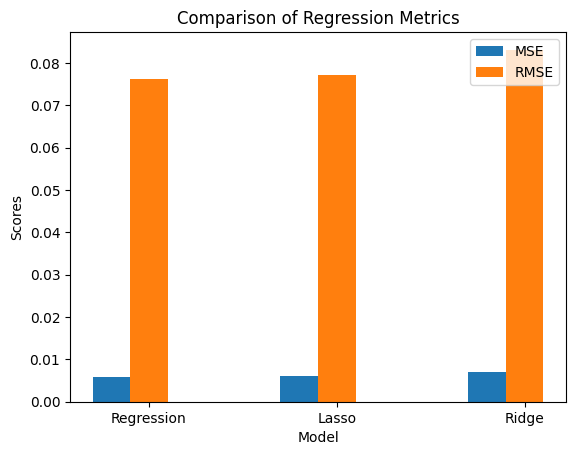

In [132]:
mse_value = [mse, mse1, mse2]
rmse_value = [rmse, rmse1, rmse2]
r2_score_value = [r2_score, r2_score1, r2_score2]

print(mse_value)
print(rmse_value)
print(r2_score_value)

positions = np.arange(len(mse_value))
bar_width = 0.2

plt.bar(positions - bar_width, mse_value, width = bar_width, label = 'MSE')
plt.bar(positions, rmse_value, width = bar_width, label = 'RMSE')
#plt.bar(positions + bar_width, r2_score_value, width = bar_width, label = 'R2_Score')

# adding labels and title
plt.xlabel('Model')
plt.ylabel('Scores')
plt.title('Comparison of Regression Metrics')

# adding the legend
plt.legend()
plt.xticks(positions, ['Regression', 'Lasso', 'Ridge'])
plt.show()

In [133]:
# Access the coefficients and intecept of the model
coefficients = linear_model.coefficients
intercept = linear_model.intercept

print(coefficients)
print(intercept)

[-0.23258832555964834,-0.12734960799740894,0.14167961610580213,0.23617172626594518,0.7037010554457026,0.0065004168776191746,-0.37146863400517716,0.7565199697133113,-1.124431296380997,-0.003643224453705067]
0.14896348019505248


Scatter plot analysis of real and predicted value

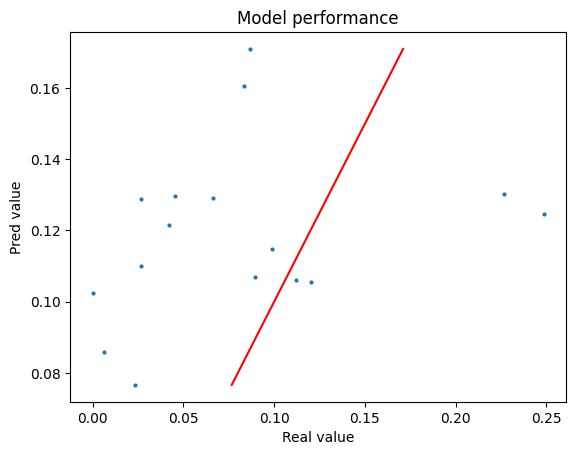

In [138]:
#Scatter plot analysis
fig, ax = plt.subplots()
min = random_predictions.selectExpr("min(prediction)").collect()[0][0]
max = random_predictions.selectExpr("max(prediction)").collect()[0][0]
plot_range = [min, max]
ax.set_title("Model performance")
ax.set_ylabel("Pred value")
ax.set_xlabel("Real value")
ax.scatter(random_predictions.select(col("mortality_final")).collect(), random_predictions.select(col('prediction')).collect(), s=4)
ax.plot(plot_range, plot_range, c="red")
plt.show()

 **Insights and Analysis based on the results:**

 Hyperparameter Tuning  used as control aspects of learning process. For regression, grid search and random search used based on regularization parameter and elastic net parameter. Based on mean sqaured error, random search parameter gives best fit. As per model evaluation, Lasso and Ridge regularization method was considered and compared with mse and rmse value. Overall, while the linear regression model performs slightly better than the Lasso and Ridge regression models in terms of MSE and RMSE, none of the models provide a good fit to the data based on the negative R2 values. This mainly occur due to null values present in most of the indicators values. When most of the row was dropped due to null value, less data is available for traning and validation.

# Student 2

In [190]:
##2nd student name:Samar
#print result
print('accuracy: ', round(accuracy, 4) * 100)
print('precision: ', round(precision, 4) * 100)
print('recall: ', round(recall, 4) * 100)
print('f1 score: ', round(f1, 4) * 100)

accuracy:  81.03
precision:  84.31
recall:  93.47999999999999
f1 score:  88.66000000000001


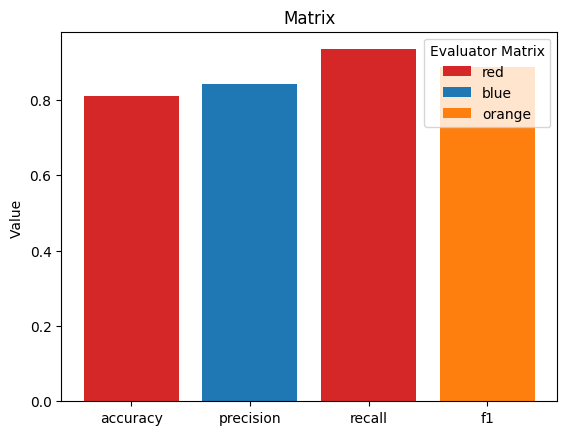

In [192]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
Metrix = ['accuracy', 'precision', 'recall', 'f1']
Value= [accuracy, precision, recall, f1]
bar_labels = ['red', 'blue', '_red', 'orange']
bar_colors = ['tab:red', 'tab:blue', 'tab:red', 'tab:orange']

ax.bar(Metrix, Value, label=bar_labels, color=bar_colors)

ax.set_ylabel('Value ')
ax.set_title('Matrix')
ax.legend(title='Evaluator Matrix')

plt.show()

**Insights and analysis based on the obtained result**


Furthermore, the WDI dataset for cross-country comparisons naturally will face complex technical problems that cannot be resolved easily. There are also other issues relating to how relevant each data submitted by each country is suitable for international cross-country comparison. Also many countries use different data collection methodologies and techniques. There are long delays in reporting data and the use of old surveys as the basis for current estimates to compensate for missing data which obviously will affect the quality of data reported. The issue of missing data in particular resulted in the accuracy result form to be 81% although I tuned hyper parameters for Grid search.
(Brown & Kros, 2003) argue that missing or inconsistent data has been a pervasive problem in data analysis since the origin of data collection and that the more data is collected, the higher the likelihood of missing data becomes. In the same vain, (Van Echelpoel & Goethals, 2018) also argue that data sets plagued with missing data and performance-affecting model parameters represent recurrent issues within the field of data mining.For the purpose of the coursework, I used Logistic Regression Model for Binary Classification for WDI based on income group categories. More specifically, I used two indicators: prevalence for anaemia and mortality in pregnant women. I then set a specific threshold value to classify countries as high and low income, any country falls above the threshold will be classified as low income (Class 1) which will need intervention in their healthcare system and any country appears below the threshold level will be categorised as high income (Class 0).

---
# **Task 6 - LSEP Considerations (5 marks)**
---

# Student 1: **Social** and **Profesional** issue of using **WDI dataset**

**1. Data Reliability**: Errors or inconsistencies in indicators value could compromise the veracity of the analysis's findings.\
**Mitigation**:Transparency and reproducibility in the results are achieved by documenting data preprocessing processes, such as the ones we established by removing null values.

**2. Difficulties with Interpretation**:The complex association between infant nutrition indicators and the infant mortality rate may be oversimplified by linear regression analysis.\
**Mitigation:** Using other analytical methods, including non-linear models, to offer a deeper understanding of the relationship.

**3. Fairness and Prejudice**: Publicly accessible datasets such as the WDI may exhibit demographic biases and disparities.\
**Mitigation:** Through successful community involvement, the World Bank Group Anti-Racism Charter, which was introduced (World Bank Group Anti-Racism Charter, 2021) aims to tackle racial prejudice and promote inclusion in the areas where we live and work.

**4. Ethical Concerns about Infant Mortality:**  Analysing data analysis regarding infant mortality raises ethical concerns about the well-being of vulnerable people.\
**Mitigation:** Beneficence and Non-maleficence are serve as the foundation of ethical decision-making in healthcare, ensuring that patient safety and wellbeing come first(Ollie, 2023).

**5. Privacy Issues:** It could include sensitive data about people or communities for some indicators. \
**Mitigation:** World Bank maintain adherence to data protection laws in order to safeguard privacy.



# Student 2: **Legal Issues** and discussion of the **Ethical** implication on WDI dataset

A recent work by (Braunack-Mayer et al., 2023) highlights the ethical issues in using big data in the health and higher education sectors. According to the study, both sectors experience ethical challenges in the use of big data. Given the fact that, many countries across the world are using different data collection methodologies and techniques, it is very difficult and extremely challenging to understand how the WDI dataset in general is strictly following the international standards for ethical and legal issues around data collection. WDI datasets do provide clear statements regarding several ethical and legal issues with data collection relating to privacy and confidentiality of the data, what type of consents used to obtain the data and the levels of transparency in doing so by the data collectors on the ground. Also there are several ethical and legal issues around the consent for data sharing, access, control and ownership.Another issue regarding the WDI dataset when using the logistic regression analysis, is that the classification of countries as low and high income could lead to reinforcing stereotypes relating to features such as the two indicators used for this coursework: maternity mortality and prevalence of anaemia in pregnancy women. It is therefore, important to understand the situation of each country very well and avoid the general approach used in the WDI dataset and aim to mitigate the risk of oversimplification in the WDI dataset.

# Conclusion:

In conclusion, WDI dataset is extremely important and useful for various types of machine learning researches but the ethical and legal considerations must be followed as per the international guidelines and standards. Moreover, it is recommend that the researchers must read and understand fully the different methodological approached used by the World bank when compiling these various WDI datasets. In doing so, we must ensure high level of transparency, fairness and privacy to minimise any potential bias and ensuring a robust mitigating strategies in place and uphold strictly the highest standards and practices in data collection and analysis.Furthermore, as team of two undertaking this coursework using the same WDI dataset for addressing different problems, we both followed carefully a peer review process reviewing and validating each other’s work. In this way we learn and implemented different approaches towards transparency and accountability by rigorous documenting all our processes and notes during the model and data analysis.

# References:

1.  https://www.kaggle.com/datasets/kaggle/world-development-indicators.
2.  World Bank. (2024).* World Development Indicators*. World Bank. https://datatopics.worldbank.org/world-development-indicators/.
3.  Van Echelpoel, W., & Goethals, P. L. M. (2018). Variable importance for sustaining macrophyte presence via random forests: data imputation and model settings.* Scientific Reports*, 8(1).https://doi.org/10.1038/s41598-018-32966-2.
4. Braunack-Mayer, A., Carolan, L., Street, J., Ha, T., Fabrianesi, B., & Carter, S. (2023). Ethical issues in big data: A qualitative study comparing responses in the health and higher education sectors.* PloS One*, 18(4), e0282285. https://doi.org/10.1371/journal.pone.0282285.
5. World Bank Group Anti-Racism Charter. (2021, November 11). World Bank. https://www.worldbank.org/en/news/statement/2021/11/11/world-bank-group-anti-racism-charter.
6. Ollie, D. (2023, July 2). Non-Maleficence In Medical Ethics. Medical School Expert. https://medicalschoolexpert.co.uk/non-maleficence-in-medical-ethics/


---

# **Task 7 - Convert ipynb to HTML for Turnitin submission [5 marks]**

---



In [ ]:
# install nbconvert (if facing the conversion error)
!pip3 install nbconvert

In [ ]:
# convert ipynb to html and submit this HTML file
!jupyter nbconvert --to html "/content/Group_16.ipynb"

[NbConvertApp] Converting notebook /content/new_project.ipynb to html
[NbConvertApp] Writing 844904 bytes to /content/new_project.html
